# Baseline - Patching comparison

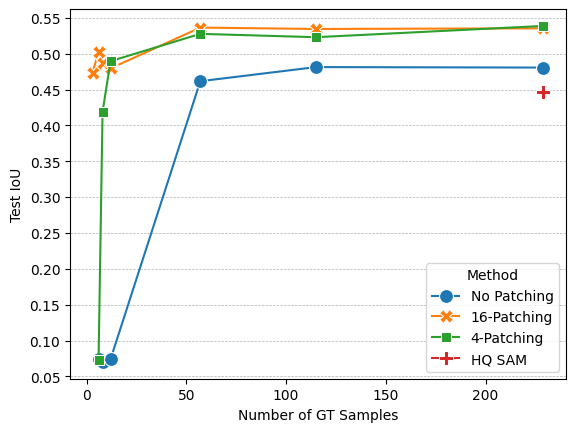

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

csv_df = pd.read_csv("wb_export_baseline.csv")
csv_df = csv_df[[col for col in csv_df.columns if col.endswith("test_IoU")]]


data = []
for col in csv_df.columns:
    method = (
        "4-Patching"
        if "patched4" in col
        else "16-Patching" if "patched16" in col else "No Patching"
    )
    n_samples = col.replace("_samples_aug - test_IoU", "").split("_")[-1]
    n_samples = int(n_samples) if n_samples != "all" else 229
    if n_samples == 1:
        continue

    test_IoU = csv_df[col].dropna().item()

    data.append(
        {"Method": method, "Number of GT Samples": n_samples, "Test IoU": test_IoU}
    )

data.append({"Method": "HQ SAM", "Number of GT Samples": 229, "Test IoU": 0.4467})
df = pd.DataFrame(data)
# plot line chart with one line per method and n_samples on x axis
import seaborn as sns

sns.lineplot(
    data=df,
    x="Number of GT Samples",
    y="Test IoU",
    hue="Method",
    markers=True,
    style="Method",
    dashes=False,
    markersize=10,
)
plt.grid(axis="y", which="both", linestyle="--", linewidth=0.5)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.05))

# Baseline - Offline ST comparison

## Create Dataframe

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
default_df = pd.read_csv("wb_export_offlineST_vs_baseline.csv")
default_df = default_df[[col for col in default_df.columns if col.endswith("test_IoU")]]

rows = []
for df in [default_df]:
    for col in df.columns:
        method = "Baseline" if "gt_vessels_patched4_baseline_" in col else "OfflineST"
        method_additions = []
        is_baseline = "gt_vessels_patched4_baseline_" in col
        mixed_labels = "mixedLabels" in col
        
        frozen_img_enc = "frozenImgEnc" in col
        confidence = "confidence" in col
        mixed_labels_ratio = None
        if mixed_labels:
            # Calculate mixed_labels_ratio. When the col name contains 0.25mixedLabels, the ratio is 0.25
            mixed_labels_ratio = col.split("mixedLabels")[0].split("_")[-1]
            if len(mixed_labels_ratio) == 0:
                mixed_labels_ratio = "0.5" if "mixedLabels0.5" in col else "0.25" if "mixedLabels0.25" in col else None
            if mixed_labels_ratio is None:
                print(f"Could not find mixed_labels_ratio for {col}")
            method_additions.append(f"Mixed Labels [{mixed_labels_ratio}]")

        if frozen_img_enc:
            method_additions.append("Frozen Image Encoder during ST")
        if confidence:
            method_additions.append("Confidence")


        if len(method_additions) > 0:
            method += f" ({', '.join(method_additions)})"
        n_samples = (
            col.replace("gt_vessels_patched4_baseline_", "")
            .replace("vessels_gt_patched4_OfflineST_fft_", "")
            .split("_")[0]
        )
        n_samples = int(n_samples) if n_samples != "all" else 229

        rows.append(
            {
                "Column Origin": col,
                "Method": method,
                "Number of Ground Truth Training Samples": n_samples,
                "Test IoU": df[col].dropna().item(),
                "Optimal Threshold": False,
                "Mixed Labels": mixed_labels,
                "Mixed Labels Ratio": mixed_labels_ratio,
                "Frozen Image Encoder during ST": frozen_img_enc,
                "Confidence": confidence,
                "Method Id": confidence
                + 2 * (mixed_labels_ratio is None)
                + 4*(mixed_labels_ratio == "0.25")
                + 8*(mixed_labels_ratio == "0.5")
                + 16 * frozen_img_enc
                + 32 * (not is_baseline),
            }
        )
df = pd.DataFrame(rows)

# Assign colors to each unique method Id
unique_method_ids = df["Method Id"].unique()
# Use a color palette suitable for color blind people
color_palette = sns.color_palette("colorblind", len(unique_method_ids))

color_map = {
    method_id: color_palette[i] for i, method_id in enumerate(unique_method_ids)
}
color_map[2] = (0.7, 0.7, 0.7)
df["Color"] = df["Method Id"].map(color_map)

# Set Alpha column based on Optimal Threshold
df["Alpha"] = df["Optimal Threshold"].apply(lambda x: 1.0 if x else 0.7)

df["Color"].dtype
df

,Column Origin,Method,Number of Ground Truth Training Samples,Test IoU,Optimal Threshold,Mixed Labels,Mixed Labels Ratio,Frozen Image Encoder during ST,Confidence,Method Id,Color,Alpha
0,vessels_gt_patched4_OfflineST_fft_all_samples_...,OfflineST (Mixed Labels [0.25]),229,0.541274,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
1,vessels_gt_patched4_OfflineST_fft_57_samples_0...,OfflineST (Mixed Labels [0.25]),57,0.533236,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
2,vessels_gt_patched4_OfflineST_fft_12_samples_0...,OfflineST (Mixed Labels [0.25]),12,0.500788,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
3,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,"OfflineST (Mixed Labels [0.5], Confidence)",8,0.498637,False,True,0.5,False,True,41,"(0.8705882352941177, 0.5607843137254902, 0.019...",0.7
4,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,OfflineST (Mixed Labels [0.5]),8,0.500752,False,True,0.5,False,False,40,"(0.00784313725490196, 0.6196078431372549, 0.45...",0.7
5,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,"OfflineST (Mixed Labels [0.25], Confidence)",8,0.490917,False,True,0.25,False,True,37,"(0.8352941176470589, 0.3686274509803922, 0.0)",0.7
6,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,OfflineST (Mixed Labels [0.25]),8,0.501866,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
7,vessels_gt_patched4_OfflineST_fft_8_samples_co...,OfflineST (Confidence),8,0.459875,False,False,None,False,True,35,"(0.8, 0.47058823529411764, 0.7372549019607844)",0.7
8,vessels_gt_patched4_OfflineST_fft_8_samples - ...,OfflineST,8,0.487888,False,False,None,False,False,34,"(0.792156862745098, 0.5686274509803921, 0.3803...",0.7
9,gt_vessels_patched4_baseline_8_samples_aug - t...,Baseline,8,0.418625,False,False,None,False,False,2,"(0.7, 0.7, 0.7)",0.7


# Performance progression comparisson vs. Baseline

,Column Origin,Method,Number of Ground Truth Training Samples,Test IoU,Optimal Threshold,Mixed Labels,Mixed Labels Ratio,Frozen Image Encoder during ST,Confidence,Method Id,Color,Alpha
0,vessels_gt_patched4_OfflineST_fft_all_samples_...,OfflineST (Mixed Labels [0.25]),229,0.541274,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
1,vessels_gt_patched4_OfflineST_fft_57_samples_0...,OfflineST (Mixed Labels [0.25]),57,0.533236,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
2,vessels_gt_patched4_OfflineST_fft_12_samples_0...,OfflineST (Mixed Labels [0.25]),12,0.500788,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
6,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,OfflineST (Mixed Labels [0.25]),8,0.501866,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
9,gt_vessels_patched4_baseline_8_samples_aug - t...,Baseline,8,0.418625,False,False,None,False,False,2,"(0.7, 0.7, 0.7)",0.7
10,gt_vessels_patched4_baseline_115_samples_aug -...,Baseline,115,0.522938,False,False,None,False,False,2,"(0.7, 0.7, 0.7)",0.7
11,gt_vessels_patched4_baseline_all_samples_aug -...,Baseline,229,0.538667,False,False,None,False,False,2,"(0.7, 0.7, 0.7)",0.7
12,gt_vessels_patched4_baseline_57_samples_aug - ...,Baseline,57,0.527622,False,False,None,False,False,2,"(0.7, 0.7, 0.7)",0.7
13,gt_vessels_patched4_baseline_12_samples_aug - ...,Baseline,12,0.489501,False,False,None,False,False,2,"(0.7, 0.7, 0.7)",0.7


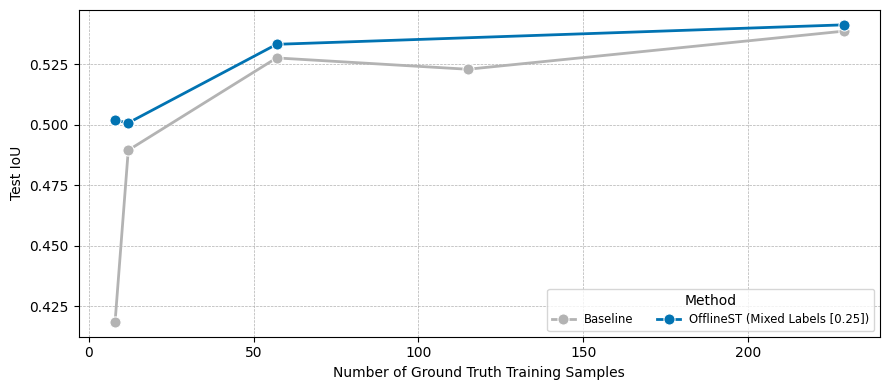

In [62]:
# plot line chart with one line per method and n_samples on x axis, with the same color for the same method
import seaborn as sns

# Create the plot
plt.figure(figsize=(9, 4))

comparison_df = df[(df["Method Id"] == 2) | (df["Method Id"] == 36)]
comparison_df = comparison_df[comparison_df["Number of Ground Truth Training Samples"]>6]
methods = comparison_df.sort_values(by=["Method Id", "Optimal Threshold"])["Method"].unique()
# Plot each method separately
for method in methods:
    subset_df = comparison_df[comparison_df["Method"] == method]
    sns.lineplot(
        data=subset_df,
        x="Number of Ground Truth Training Samples",
        y="Test IoU",
        color=subset_df["Color"].iloc[0],
        label=method,
        linewidth=2,
        markers=True,
        markersize=8,
        marker="o",
    )

plt.legend(
    title="Method",
    #loc="upper center",
    #bbox_to_anchor=(0.5, 1.1),
    ncol=2,
    fontsize="small",
)
plt.grid(axis="both", which="both", linestyle="--", linewidth=0.5)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.025))
plt.tight_layout()
comparison_df

# Comparison for specific GT subset (small)

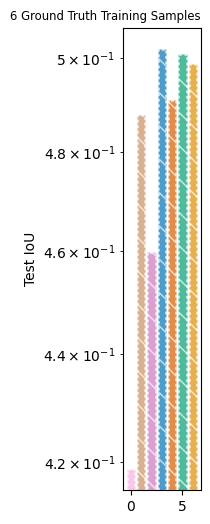

In [25]:
import matplotlib.pyplot as plt

df8 = df[df["Number of Ground Truth Training Samples"] == 8]
method_ids = df8.sort_values(by=["Method Id"])["Method Id"].unique()
# Plot bar chart with logarithmic y axis
plt.figure(figsize=(1, 6))

for i, method in enumerate(method_ids):
    subset_df = df8[df8["Method Id"] == method]
    # subset_df contains both thresholded and unthresholded results

    for _, row in subset_df.iterrows():
        edgecolor = "white" if not row["Optimal Threshold"] else None
        linestyle = (0, (1, 1)) if not row["Optimal Threshold"] else None
        plt.bar(
            i,
            row["Test IoU"],
            color=row["Color"],
            alpha=row["Alpha"],
            edgecolor=edgecolor,
            linestyle=linestyle,
            linewidth=2,
            zorder=(
                1 if row["Optimal Threshold"] else 2
            ),  # Ensure thresholded bars are drawn on top
            hatch="\\" if not row["Optimal Threshold"] else None,
        )
plt.yscale("log")
plt.ylabel("Test IoU")
plt.title("6 Ground Truth Training Samples", loc="right", fontsize="small")
# plt.grid(axis="y", which="both", linestyle="--", linewidth=0.5)
# plt.tight_layout()
plt.show()

# Comparison for specific GT subset (large with confidence)

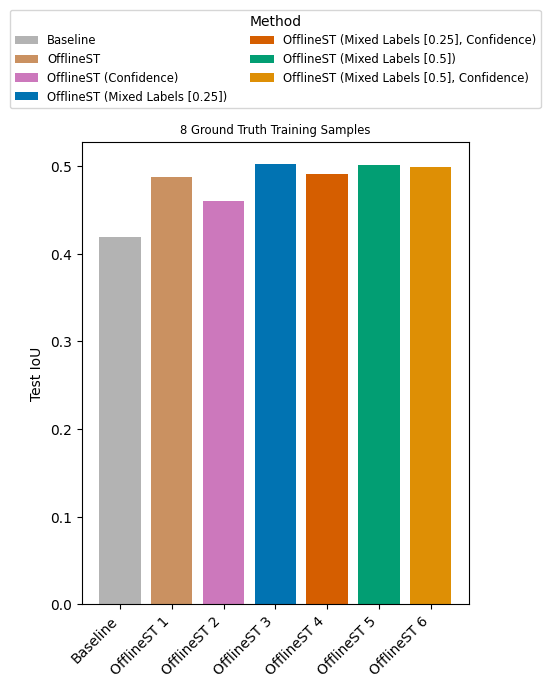

,Column Origin,Method,Number of Ground Truth Training Samples,Test IoU,Optimal Threshold,Mixed Labels,Mixed Labels Ratio,Frozen Image Encoder during ST,Confidence,Method Id,Color,Alpha
3,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,"OfflineST (Mixed Labels [0.5], Confidence)",8,0.498637,False,True,0.5,False,True,41,"(0.8705882352941177, 0.5607843137254902, 0.019...",0.7
4,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,OfflineST (Mixed Labels [0.5]),8,0.500752,False,True,0.5,False,False,40,"(0.00784313725490196, 0.6196078431372549, 0.45...",0.7
5,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,"OfflineST (Mixed Labels [0.25], Confidence)",8,0.490917,False,True,0.25,False,True,37,"(0.8352941176470589, 0.3686274509803922, 0.0)",0.7
6,vessels_gt_patched4_OfflineST_fft_8_samples_mi...,OfflineST (Mixed Labels [0.25]),8,0.501866,False,True,0.25,False,False,36,"(0.00392156862745098, 0.45098039215686275, 0.6...",0.7
7,vessels_gt_patched4_OfflineST_fft_8_samples_co...,OfflineST (Confidence),8,0.459875,False,False,None,False,True,35,"(0.8, 0.47058823529411764, 0.7372549019607844)",0.7
8,vessels_gt_patched4_OfflineST_fft_8_samples - ...,OfflineST,8,0.487888,False,False,None,False,False,34,"(0.792156862745098, 0.5686274509803921, 0.3803...",0.7
9,gt_vessels_patched4_baseline_8_samples_aug - t...,Baseline,8,0.418625,False,False,None,False,False,2,"(0.7, 0.7, 0.7)",0.7


In [ ]:
import matplotlib.pyplot as plt

df8 = df[df["Number of Ground Truth Training Samples"] == 8]
method_ids = df8.sort_values(by=["Method Id", "Optimal Threshold"])["Method Id"].unique()
plt.figure(figsize=(5, 6))
method_short_labels = ["Baseline", "OfflineST 1", "OfflineST 2", "OfflineST 3", "OfflineST 4", "OfflineST 5", "OfflineST 6"]
for i, method in enumerate(method_ids):
    subset_df = df8[df8["Method Id"] == method]
    for _, row in subset_df.iterrows():
        plt.bar(
            method_short_labels[i],
            row["Test IoU"],
            color=row["Color"],
            label=row["Method"],
        )
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test IoU")
plt.title("8 Ground Truth Training Samples", loc="center", fontsize="small")
plt.legend(
    title="Method",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.3),
    ncol=2,
    fontsize="small",
)
plt.show()

df8

/tmp/ipykernel_3356829/3979229837.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8[df8["Method Id"] != 2 ][df8["Confidence"]]["Test IoU"].mean()


0.4831429112225724

In [61]:
df8[df8["Method Id"] != 2][~df8["Confidence"]]["Test IoU"].mean() - df8[df8["Method Id"] != 2 ][df8["Confidence"]]["Test IoU"].mean()

/tmp/ipykernel_3356829/3674385550.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8[df8["Method Id"] != 2][~df8["Confidence"]]["Test IoU"].mean() - df8[df8["Method Id"] != 2 ][df8["Confidence"]]["Test IoU"].mean()
/tmp/ipykernel_3356829/3674385550.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8[df8["Method Id"] != 2][~df8["Confidence"]]["Test IoU"].mean() - df8[df8["Method Id"] != 2 ][df8["Confidence"]]["Test IoU"].mean()


0.013692146927871574